In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.signal as signal
import math

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Collect the necessary data 
# Note: sampling rate of earbuds is 100Hz
# Note: P02-P06 are missing on left earbuds

# For some subjects device is restarted during experiement causing time series to be inconsistent
# There  6 subjects with right earbud who had only 1 or 0 restarts during trial: P06, P08, P10, P13, P14, P17
# For now energy expenditure research can focus on these subjects since data after restart can be discarded if necessary

pd.options.mode.copy_on_write = True

def rescale_timestamps(df, subject):
    """
    Helper function for ignoring (for now) restarted samples
    and rescale timestamps with special case of min-max normalisation

    x' = x-min(x)
    """

    restart_indices = []
    
    # Find restart points
    restart_mask = df['timestamp'].shift() > df['timestamp']
    restart_indices = restart_mask.index[restart_mask].to_list()

    if restart_indices:
        # Pick only the first restart point. This is intentional (for now) 
        # only subjects with more than 1 restart points are ignored
        df = df.loc[restart_indices[0]:]
        display(subject)        
        display(df)

    df["timestamp"] = df["timestamp"] - min(df["timestamp"])
        
    
    #ind_min = np.argmin(df["timestamp"])
    #display(df["timestamp"].loc[ind_min:ind_min+10])
    #print(restart_indices)
    return df

def clean_timestamps(df, subject):

    # Remove non-numeric entries
    df_timestamps = pd.to_numeric(df["timestamp"], errors="coerce")
    nulls = pd.isnull(df_timestamps)
    df["timestamp"] = df_timestamps
    df = df[~nulls]

    # Change dtype to int64 and rescale time stamps to start from 0
    df["timestamp"] = df["timestamp"].to_numpy(dtype=np.int64)
    df = rescale_timestamps(df, subject)
    #display(df)
    return df
    
    
root = "original_dataset/dataset"
subject_dirs = sorted([d for d in os.listdir(root) if d.startswith("P")]) # Get only data related to each subject and sort it

dataframes_right = []

indices_left = []
dataframes_left = []

for i, subject in enumerate(subject_dirs):
    earbud_path = f"{root}/{subject}/EARBUDS/"
    
    earbuds_left = [d for d in os.listdir(earbud_path) if d.startswith(f'{subject}-imu-l')]
    earbuds_right = [d for d in os.listdir(earbud_path) if d.startswith(f'{subject}-imu-r')]

    if earbuds_left:
        path = os.path.join(earbud_path, earbuds_left[0])
        df = pd.read_csv(path)
        #df = clean_timestamps(df)

        #print("Left bud")
        #print(df["timestamp"].iloc[-1] - df["timestamp"].iloc[0])

        dataframes_left.append(df)
        indices_left.append(subject)

    path = os.path.join(earbud_path, earbuds_right[0])
    df = pd.read_csv(path)
    df = clean_timestamps(df, subject)
    dataframes_right.append(df)


df_subjects_right = pd.DataFrame({"Device": ["EARBUD_R"]*len(dataframes_right), "Data": dataframes_right}, index=[subject_dirs])
df_subjects_left = pd.DataFrame({"Device": ["EARBUD_L"]*len(dataframes_left), "Data": dataframes_left}, index=[indices_left])
    
display(df_subjects_right)
display(df_subjects_left)

display(df_subjects_right["Data"].iloc[0])




/tmp/ipykernel_7246/1974678459.py:71: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_7246/1974678459.py:81: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


'P01'

,timestamp,ax,ay,az,gx,gy,gz
31,9311,16051,867,2510,-574,694,964
32,9320,16127,875,2471,-411,753,1016
33,9330,16208,895,2431,-248,720,1163
34,9339,16286,945,2398,-103,643,1327
35,9349,16316,987,2367,18,617,1410
...,...,...,...,...,...,...,...
222015,2140357,3292,15187,4645,-75,67,60
222016,2140367,3326,15226,4632,-82,70,38
222017,2140376,3363,15260,4629,-85,97,30
222018,2140386,3384,15290,4667,-77,134,36


'P02'

,timestamp,ax,ay,az,gx,gy,gz
32,1637860481905,-4825,14248,-5969,22,11,6
33,1637860481915,-4815,14225,-5984,16,0,-1
34,1637860481925,-4820,14258,-6028,12,-13,-15
35,1637860481934,-4827,14240,-6044,11,-10,-20
36,1637860481944,-4815,14210,-6029,34,7,1
...,...,...,...,...,...,...,...
289642,1637863262161,13650,-3695,8304,-3,-17,24
289643,1637863262171,13665,-3686,8295,-9,-16,26
289644,1637863262181,13660,-3675,8307,-18,-17,23
289645,1637863262190,13650,-3699,8296,-19,-16,23


'P03'

,timestamp,ax,ay,az,gx,gy,gz
31,1637943563655,15727,-1454,1116,-248,-987,-664
32,1637943563665,15809,-1590,1088,1317,-1822,-9
33,1637943563674,15690,-1634,1104,2440,-2677,732
34,1637943563684,15641,-1314,1142,2647,-2921,651
35,1637943563694,16268,-1174,1180,1924,-3144,1074
...,...,...,...,...,...,...,...
235466,1637944326335,-6723,14776,-1747,184,-737,47
235467,1637944326345,-6719,14754,-1756,190,-705,72
235468,1637944326354,-6709,14744,-1767,197,-673,95
235469,1637944326364,-6699,14720,-1764,204,-638,116


'P04'

,timestamp,ax,ay,az,gx,gy,gz
32,1637949696875,-10099,-6845,-10856,617,312,-186
33,1637949696885,-10072,-6930,-10871,603,309,-178
34,1637949696894,-10018,-7009,-10879,588,320,-183
35,1637949696904,-10007,-7100,-10860,568,309,-200
36,1637949696914,-9939,-7103,-10851,546,269,-230
...,...,...,...,...,...,...,...
255969,1637952579912,13386,5795,2419,5114,-2153,2492
255970,1637952579922,13466,6400,2514,2161,-2629,2437
255971,1637952579931,13561,6708,2586,-1798,-3295,2702
255972,1637952579941,13665,6566,2666,-4757,-4206,3321


'P05'

,timestamp,ax,ay,az,gx,gy,gz
31,1638178413710,-5756,14308,-4914,-25,-14,39
32,1638178413719,-5732,14295,-4916,-26,-10,37
33,1638178413729,-5712,14303,-4903,-24,-5,34
34,1638178413738,-5737,14307,-4885,-20,-5,30
35,1638178413748,-5752,14307,-4870,-15,-13,21
...,...,...,...,...,...,...,...
256452,1638180875351,-2374,10985,-11691,-4,-25,18
256453,1638180875361,-2371,10992,-11681,-5,-26,19
256454,1638180875370,-2373,10995,-11685,-9,-26,19
256455,1638180875380,-2379,10982,-11680,-6,-23,18


/tmp/ipykernel_7246/1974678459.py:81: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


'P07'

,timestamp,ax,ay,az,gx,gy,gz
32,1638199892258,-9211,4946,-12420,-170,12,437
33,1638199892267,-9218,4856,-12532,-166,33,381
34,1638199892277,-9203,4792,-12635,-153,51,310
35,1638199892286,-9196,4798,-12593,-128,102,227
36,1638199892296,-9199,4797,-12556,-105,107,127
...,...,...,...,...,...,...,...
230304,1638202102869,2255,-10292,12694,-2,-28,15
230305,1638202102878,2285,-10289,12699,6,-33,13
230306,1638202102888,2274,-10286,12710,15,-37,14
230307,1638202102898,2277,-10284,12705,9,-33,14


'P08'

,timestamp,ax,ay,az,gx,gy,gz
32,1638208673162,-716,6019,15314,-41,-22,-4
33,1638208673172,-707,6046,15302,-36,-26,-23
34,1638208673181,-704,6108,15293,-28,-44,-22
35,1638208673191,-730,6171,15301,-21,-54,-15
36,1638208673201,-728,6169,15302,-11,-66,23
...,...,...,...,...,...,...,...
221995,1638210804007,-1810,-15682,-4542,45,-27,11
221996,1638210804017,-1817,-15676,-4540,40,-28,18
221997,1638210804026,-1820,-15685,-4538,35,-34,16
221998,1638210804036,-1819,-15691,-4550,46,-41,17


'P09'

,timestamp,ax,ay,az,gx,gy,gz
31,1638263904735,-1396,-4402,-15644,-13,-30,28
32,1638263904744,-1397,-4397,-15645,-16,-26,27
33,1638263904754,-1394,-4395,-15651,-13,-26,27
34,1638263904764,-1410,-4387,-15630,-9,-29,22
35,1638263904773,-1411,-4403,-15643,-7,-33,31
...,...,...,...,...,...,...,...
214613,1638265964732,-131,-9853,13227,11,-17,15
214614,1638265964741,-120,-9866,13225,10,-24,-2
214615,1638265964751,-95,-9871,13225,-10,-30,25
214616,1638265964760,-102,-9864,13212,-23,-34,36


'P10'

,timestamp,ax,ay,az,gx,gy,gz
31,1638271404000,-701,7150,-14437,-2,-13,-22
32,1638271404009,-693,7149,-14452,-6,-15,-17
33,1638271404019,-692,7151,-14443,2,-14,-10
34,1638271404028,-692,7155,-14421,1,-17,-9
35,1638271404038,-682,7150,-14433,3,-21,-14
...,...,...,...,...,...,...,...
263091,1638273929376,5835,7890,-13575,-1318,-319,1356
263092,1638273929385,5653,7827,-12848,-1234,-450,1379
263093,1638273929395,5382,7685,-12062,-1178,-567,1399
263094,1638273929404,5006,7564,-11359,-1083,-657,1317


'P11'

,timestamp,ax,ay,az,gx,gy,gz
32,1638284825967,-2787,-13115,-9310,-65,-198,3
33,1638284825976,-2810,-13077,-9375,-88,-176,15
34,1638284825986,-2836,-13081,-9397,-120,-144,38
35,1638284825996,-2841,-13066,-9442,-139,-114,62
36,1638284826005,-2807,-13060,-9483,-172,-93,69
...,...,...,...,...,...,...,...
317995,1638287878421,710,-10688,12578,-4,-25,16
317996,1638287878431,722,-10679,12568,-42,-8,28
317997,1638287878440,705,-10657,12539,-46,-10,22
317998,1638287878450,694,-10688,12531,-9,-26,11


'P12'

,timestamp,ax,ay,az,gx,gy,gz
31,1638528784189,1270,15241,-5280,49,-67,11
32,1638528784199,1264,15240,-5290,52,-72,8
33,1638528784208,1263,15218,-5296,42,-75,6
34,1638528784218,1245,15212,-5285,43,-77,4
35,1638528784228,1256,15229,-5293,49,-83,-4
...,...,...,...,...,...,...,...
457564,1638532252847,557,-12923,10322,286,-110,85
457565,1638532252857,625,-12911,10172,201,78,-187
457566,1638532252866,631,-12472,10169,409,-173,38
457567,1638532252876,775,-12954,10297,-26,43,-156


'P13'

,timestamp,ax,ay,az,gx,gy,gz
32,1638297002679,-5599,7145,-13362,-55,-33,48
33,1638297002688,-5602,7146,-13371,-52,-17,48
34,1638297002698,-5600,7156,-13349,-43,-3,43
35,1638297002708,-5586,7167,-13303,-38,4,44
36,1638297002717,-5594,7173,-13301,-39,8,51
...,...,...,...,...,...,...,...
233995,1638299248724,8590,-332,-11723,-4337,1117,5247
233996,1638299248733,954,-3052,-20580,-8379,-4396,3120
233997,1638299248743,16645,-4066,-13479,-4158,-1611,5484
233998,1638299248752,4808,-2827,-11434,6390,14144,-2890


'P14'

,timestamp,ax,ay,az,gx,gy,gz
32,1638371990787,1010,15786,-1991,-226,-384,-403
33,1638371990797,1091,16131,-2411,-252,-403,-529
34,1638371990806,1167,16320,-2640,-175,-311,-488
35,1638371990816,1168,16251,-2625,-41,-170,-314
36,1638371990826,1138,16067,-2614,48,-88,-153
...,...,...,...,...,...,...,...
227995,1638374179232,1555,-8900,13837,-31,-24,21
227996,1638374179242,1547,-8914,13812,-40,-21,22
227997,1638374179251,1567,-8919,13813,-20,-23,22
227998,1638374179261,1557,-8928,13817,6,-28,15


'P15'

,timestamp,ax,ay,az,gx,gy,gz
31,1638356615067,26,7477,-14211,-13,95,-81
32,1638356615077,39,7428,-14244,-15,78,-87
33,1638356615086,33,7423,-14232,-25,57,-99
34,1638356615096,65,7387,-14296,-44,58,-125
35,1638356615105,48,7373,-14340,-39,55,-143
...,...,...,...,...,...,...,...
223628,1638358924607,2506,15995,-191,-3,-22,17
223629,1638358924617,2507,16006,-178,-3,-21,14
223630,1638358924626,2511,16005,-183,-2,-23,13
223631,1638358924636,2494,16000,-192,-1,-20,13


'P16'

,timestamp,ax,ay,az,gx,gy,gz
32,1638382918698,-882,15215,-5174,146,-241,8
33,1638382918708,-896,15215,-5211,145,-254,1
34,1638382918717,-900,15227,-5233,146,-262,-4
35,1638382918727,-906,15236,-5283,138,-263,-6
36,1638382918737,-921,15252,-5296,131,-263,6
...,...,...,...,...,...,...,...
359258,1638386691740,17190,-7213,-5165,32724,-28447,-12464
359259,1638386691749,19674,4108,-2948,32764,-32764,9276
359260,1638386691759,19159,10809,3045,21056,-31278,24390
359261,1638386691769,15063,9536,4140,-22226,-13213,29739


'P17'

,timestamp,ax,ay,az,gx,gy,gz
32,1638464427154,-8297,10046,-9313,662,-202,28
33,1638464427164,-8319,9986,-9360,654,-260,56
34,1638464427173,-8330,9911,-9376,612,-307,81
35,1638464427183,-8351,9824,-9371,561,-343,108
36,1638464427193,-8371,9766,-9396,492,-366,120
...,...,...,...,...,...,...,...
233995,1638466673209,-14536,6128,-2910,1482,419,580
233996,1638466673218,-14592,6201,-3083,1377,493,608
233997,1638466673228,-14628,6210,-3116,1169,580,637
233998,1638466673237,-14652,6185,-3137,1078,562,569


,Device,Data
P01,EARBUD_R,timestamp ax ay az gx g...
P02,EARBUD_R,timestamp ax ay az gx gy ...
P03,EARBUD_R,timestamp ax ay az gx ...
P04,EARBUD_R,timestamp ax ay az gx ...
P05,EARBUD_R,timestamp ax ay az gx gy ...
P06,EARBUD_R,timestamp ax ay az gx g...
P07,EARBUD_R,timestamp ax ay az gx g...
P08,EARBUD_R,timestamp ax ay az gx gy ...
P09,EARBUD_R,timestamp ax ay az gx gy ...
P10,EARBUD_R,timestamp ax ay az gx g...


,Device,Data
P01,EARBUD_L,timestamp ax ay a...
P07,EARBUD_L,timestamp ax ay az gx...
P08,EARBUD_L,timestamp ax ay az gx...
P09,EARBUD_L,timestamp ax ay az gx ...
P10,EARBUD_L,timestamp ax ay az gx...
P11,EARBUD_L,timestamp ax ay az gx...
P12,EARBUD_L,timestamp ax ay az gx ...
P13,EARBUD_L,timestamp ax ay az gx ...
P14,EARBUD_L,timestamp ax ay az ...
P15,EARBUD_L,timestamp ax ay az gx ...


,timestamp,ax,ay,az,gx,gy,gz
31,0,16051,867,2510,-574,694,964
32,9,16127,875,2471,-411,753,1016
33,19,16208,895,2431,-248,720,1163
34,28,16286,945,2398,-103,643,1327
35,38,16316,987,2367,18,617,1410
...,...,...,...,...,...,...,...
222015,2131046,3292,15187,4645,-75,67,60
222016,2131056,3326,15226,4632,-82,70,38
222017,2131065,3363,15260,4629,-85,97,30
222018,2131075,3384,15290,4667,-77,134,36


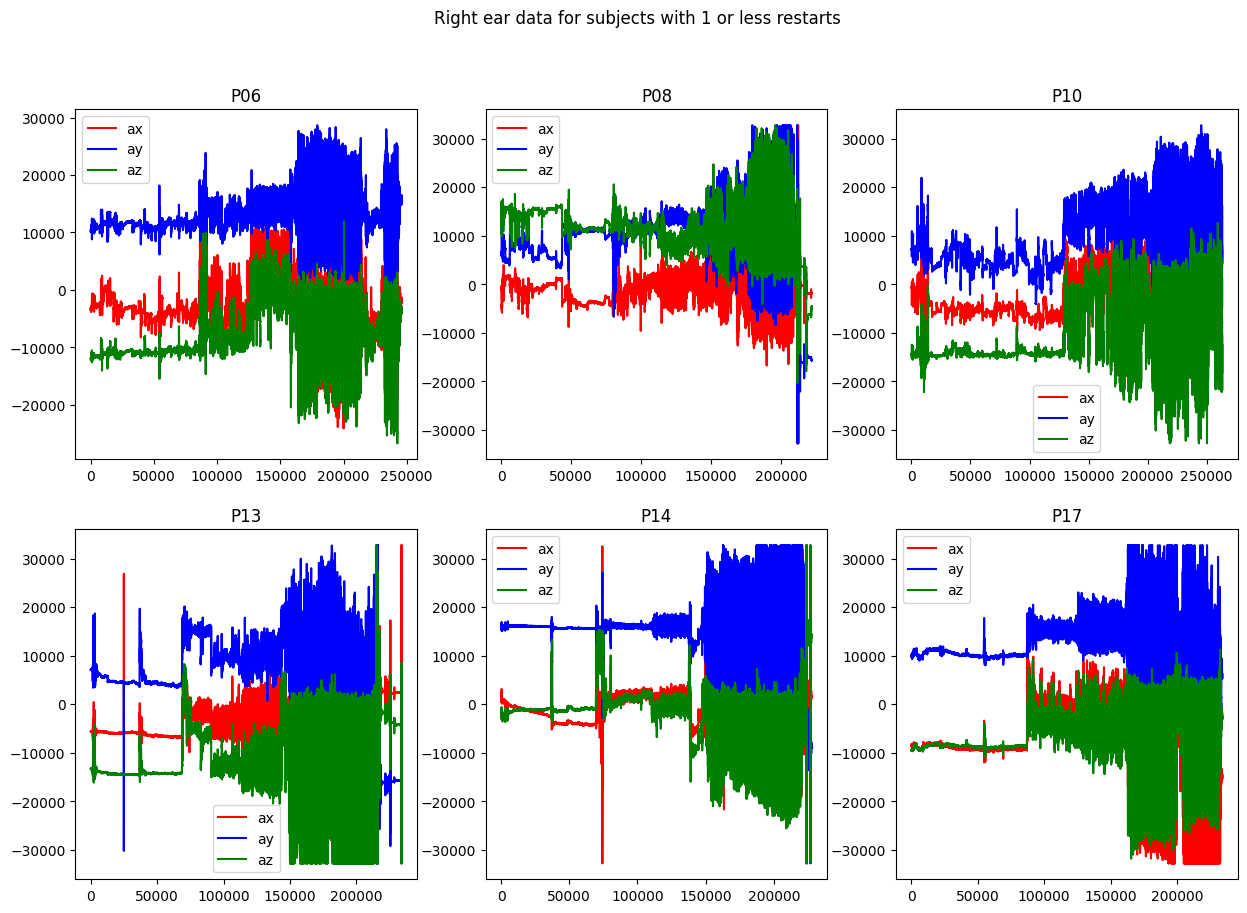

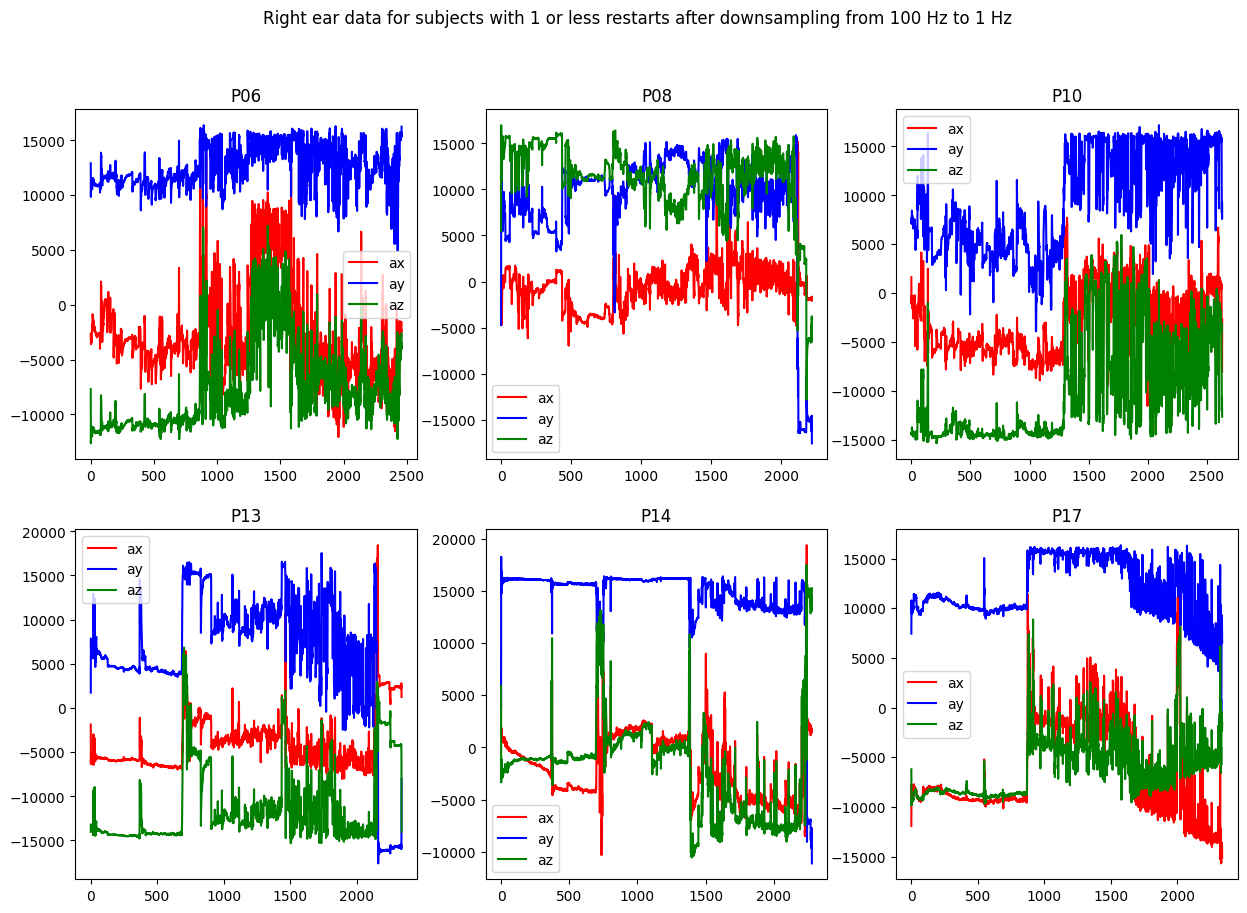

In [3]:
# Visualize the data

# Pick 6 subjects who had only 1 or 0 restarts during trial

SAMPLE_RATE = 100 # Hz
DOWNSAMPLED_RATE = 1 # Hz
WINDOW_SIZE = 60 #  time (s) * sampling_frequency (Hz)


def plot_all(df, processing_func=None, title=""):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.ravel()

    for i, row in enumerate(df.iterrows()):
        data = row[1].iloc[1]

        if processing_func is not None:
            data = processing_func(data)

        x = np.arange(0, len(data))
        ax_ = data["ax"]
        ay = data["ay"]
        az = data["az"]

        ax[i].plot(x, ax_, "r", label="ax")
        ax[i].plot(x, ay, "b", label="ay")
        ax[i].plot(x, az, "g", label="az")
        ax[i].set_title(df.index[i][0])
        ax[i].legend()
    
    fig.suptitle(title)
    plt.show()

def downsample(data):
    ratio = SAMPLE_RATE / DOWNSAMPLED_RATE
    data_resampled = signal.resample(data, int(math.ceil(len(data) / ratio)))
    timestamp_resampled = data["timestamp"].iloc[::int(ratio)]
    data_resampled[:, 0] = timestamp_resampled
    data = pd.DataFrame(columns=data.columns, data=data_resampled)
    return data

def rolling_win(data):

    # Centered rolling average
    data["ax"] = data["ax"].rolling(window=WINDOW_SIZE, center=True, min_periods=WINDOW_SIZE).mean()
    data["ay"] = data["ay"].rolling(window=WINDOW_SIZE, center=True, min_periods=WINDOW_SIZE).mean()
    data["az"] = data["az"].rolling(window=WINDOW_SIZE, center=True, min_periods=WINDOW_SIZE).mean()

    return data

def downsample_and_roll(data):
    data = downsample(data)
    return rolling_win(data)

subjects = ["P06", "P08", "P10", "P13", "P14", "P17"]
right_ear_subs = df_subjects_right.loc[subjects]


# Raw data no preprocessing
plot_all(right_ear_subs, title="Right ear data for subjects with 1 or less restarts")

# Raw data after downsampling from 100hz to 1hz
plot_all(right_ear_subs, processing_func=downsample, title="Right ear data for subjects with 1 or less restarts after downsampling from 100 Hz to 1 Hz")

# Filtered data with rolling no downsampling 
#plot_all(right_ear_subs, processing_func=rolling_win, title="Right ear data for subjects with 1 or less restarts with rolling average and no downsampling (Winsize = time * sampling rate)")

# Filtered data with rolling window with downsampling and normalisation 
#plot_all(right_ear_subs, processing_func=downsample_and_roll, title="Right ear data for subjects with 1 or less restarts with rolling average and downsampling (Winsize = time * sampling rate)")

(('P06',),
 Device                                             EARBUD_R
 Data              timestamp    ax     ay     az   gx   g...
 Name: (P06,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,-2627.617457,12909.541222,-7683.901237,-46.638221,160.724099,-81.580645
1,960.0,-3497.532091,9845.455528,-12633.229957,-46.478767,-113.326518,-16.064266
2,1920.0,-3585.150264,10624.574982,-11318.951222,-2.728953,-5.261031,58.567627
3,2880.0,-3302.863110,10421.168498,-11941.015359,-72.349508,-23.555821,60.947411
4,3840.0,-3207.833564,10905.998082,-11267.500086,-16.449599,-44.240685,103.434803
...,...,...,...,...,...,...,...
2455,2356800.0,-3359.605173,15442.981596,-3770.402951,-112.487348,-113.781950,71.884821
2456,2357760.0,-2911.190080,15337.118845,-3985.297951,60.230183,-193.397795,266.447392
2457,2358720.0,-2268.573181,15752.700512,-3461.674063,-16.638958,-141.471816,30.195812
2458,2359680.0,-2409.064492,15306.372770,-4039.947825,-24.566370,-58.558080,131.379798


(('P08',),
 Device                                             EARBUD_R
 Data              timestamp    ax     ay     az  gx  gy ...
 Name: (P08,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,-1098.189128,-4725.070673,5500.012666,21.977062,-10.487918,101.859050
1,960.0,-932.622675,8105.086477,16970.997421,42.507810,-39.529710,-251.729708
2,1920.0,-719.425577,5354.780102,14191.425907,25.367505,-85.314728,202.218502
3,2880.0,-1169.264624,7142.453735,15684.937537,68.655381,215.105482,-517.742698
4,3840.0,-3789.682780,7080.165077,13569.674231,713.849884,473.512243,51.155734
...,...,...,...,...,...,...,...
2215,2126400.0,-1927.707898,-15768.528014,-5998.600709,143.103388,-29.915898,-33.408900
2216,2127360.0,-1681.339520,-14940.773060,-4644.431293,41.329097,-10.350548,70.943605
2217,2128320.0,-1960.739487,-16267.665265,-5628.492027,34.615878,-43.205233,-41.779069
2218,2129280.0,-1643.069260,-14560.316861,-3783.633031,17.561025,-4.734436,85.132078


(('P10',),
 Device                                             EARBUD_R
 Data              timestamp    ax    ay     az    gx   g...
 Name: (P10,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,1616.766980,7648.140955,-14343.584124,-167.721243,-2.975029,854.999781
1,960.0,-1129.393461,7138.766310,-14464.253433,8.336615,-174.265282,172.124554
2,1920.0,-229.046682,7279.612833,-14387.877776,-35.143081,278.627017,-492.472602
3,2880.0,-815.796227,7080.691681,-14523.543509,64.032133,-528.749092,825.981383
4,3840.0,-969.504580,7861.245804,-14016.461783,-472.540949,1889.206127,-3390.862571
...,...,...,...,...,...,...,...
2626,2520960.0,-3827.250793,10519.292303,-11182.397902,1649.042455,-549.640832,-47.844715
2627,2521920.0,-6681.190958,8214.924312,-12085.360032,-1451.979705,917.558239,-2128.689230
2628,2522880.0,-7874.089188,9375.112297,-10546.077602,135.406839,195.080903,-47.053624
2629,2523840.0,-8114.034267,7580.894152,-11981.808064,1011.532030,-604.312795,1187.050626


(('P13',),
 Device                                             EARBUD_R
 Data              timestamp     ax    ay     az     gx  ...
 Name: (P13,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,-1880.898286,1744.099378,-14024.743931,206.470804,1550.721625,13.902219
1,960.0,-6331.849969,7871.279136,-13170.830765,-335.555540,-232.500532,-68.018322
2,1920.0,-5193.991088,6751.128333,-13430.909486,215.840629,113.201068,104.289329
3,2880.0,-5916.867659,7395.489303,-13252.634200,-207.685533,-119.535164,-49.780724
4,3840.0,-5438.111437,7145.033610,-13264.687744,148.704948,34.012492,109.532181
...,...,...,...,...,...,...,...
2335,2241600.0,2579.260709,-15911.090738,-4309.006747,231.377053,104.730023,-75.073891
2336,2242560.0,2131.438649,-15450.782439,-4121.295960,-321.897341,-191.473344,120.920211
2337,2243520.0,2807.050825,-15971.459170,-4354.298155,425.744016,250.409986,-150.511324
2338,2244480.0,1699.722957,-14795.789402,-5357.460626,-1613.098830,-1165.800654,206.099888


(('P14',),
 Device                                             EARBUD_R
 Data              timestamp    ax     ay     az   gx   g...
 Name: (P14,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,1315.221623,3671.873396,5885.647528,-116.188710,12.967746,91.975931
1,960.0,1615.341372,18251.658402,-3360.584641,166.949569,-93.059810,-32.462629
2,1920.0,1442.338383,14709.819637,-1466.128072,-117.426528,116.014959,95.126251
3,2880.0,1852.756329,16886.130590,-1924.370881,-71.892299,44.159988,-21.039221
4,3840.0,1509.069036,15384.165707,-1137.038012,86.263877,-188.291580,-2.013540
...,...,...,...,...,...,...,...
2275,2184000.0,1822.976745,-9154.105498,14344.525322,61.498416,-66.615452,-45.722760
2276,2184960.0,1392.470699,-8325.495678,13373.151907,-132.726555,-17.062028,151.131974
2277,2185920.0,1708.748596,-9697.178412,14385.480913,129.306264,-42.177501,-99.458834
2278,2186880.0,1415.618944,-7718.535333,13043.088920,-105.328897,-20.732859,114.581531


(('P17',),
 Device                                             EARBUD_R
 Data              timestamp     ax     ay    az    gx   ...
 Name: (P17,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,-11923.401177,7432.446899,-6216.180478,955.466333,-340.658674,450.186276
1,960.0,-7754.751467,10786.152897,-9861.498109,-289.927438,119.731568,-165.126498
2,1920.0,-8999.023802,9460.448244,-9252.075017,194.175443,-122.582237,157.212209
3,2880.0,-8196.605430,10479.766168,-9446.266046,-144.246513,27.525770,-86.173064
4,3840.0,-8784.382865,9761.434411,-9274.026291,85.857637,-48.082888,135.981547
...,...,...,...,...,...,...,...
2335,2241610.0,-13584.538818,9307.965502,-409.159176,21.200880,38.584878,-447.730900
2336,2242570.0,-14047.693641,7805.120971,-1965.302459,-139.703248,150.409654,181.741775
2337,2243530.0,-13837.372074,8732.285514,-1165.056982,394.268014,-235.699519,-8.960060
2338,2244490.0,-13838.241045,8051.609508,-2322.091406,-1097.853395,680.519482,-266.022323


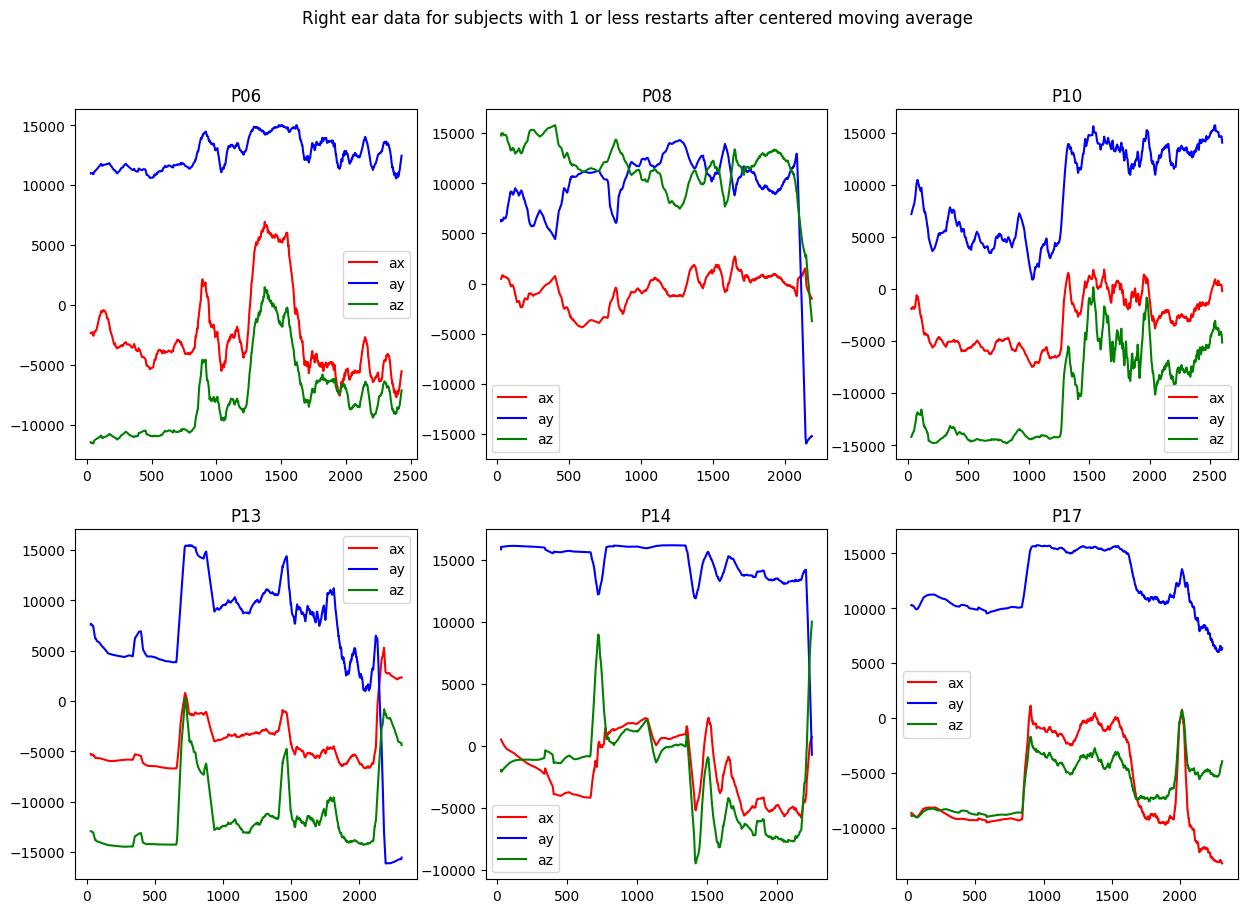

In [6]:
# Preprocessing from Amarasinghe et al [1]

# centred moving average

#N_ORDER = 3 # For butterworth
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

for i, row in enumerate(right_ear_subs.iterrows()):
    data = row[1].iloc[1]
    display(row)
    data = downsample(data)
    #data[["ax", "ay", "az"]] = StandardScaler().fit_transform(data[["ax", "ay", "az"]])
    display(data)
    data = rolling_win(data)

    ax_ = data["ax"]
    ay = data["ay"]
    az = data["az"]

    #display(data)
    #ax_ = data["ax"].rolling(window=WINDOW_SIZE, center=True, min_periods=WINDOW_SIZE).mean()
    #ay = data["ay"].rolling(window=WINDOW_SIZE, center=True, min_periods=WINDOW_SIZE).mean()
    #az = data["az"].rolling(window=WINDOW_SIZE, center=True, min_periods=WINDOW_SIZE).mean()


    #display(ax_)
    #display(ay)
    #display(az)

    x = np.arange(0, len(ax_))

    # Discard the first and the last window 
    ax[i].plot(x, ax_, "r", label="ax")
    ax[i].plot(x, ay, "b", label="ay")
    ax[i].plot(x, az, "g", label="az")
    ax[i].set_title(right_ear_subs.index[i][0])
    ax[i].legend()

fig.suptitle("Right ear data for subjects with 1 or less restarts after centered moving average")
#plt.savefig("clean.svg")
plt.show()




In [5]:
import os
import pickle


dirs = sorted(os.listdir("../preprocessed_dataset/"), key=lambda s: int(s.split("P")[1])) # Hacky way to sort by number in file name

paths = [os.path.join(f"../preprocessed_dataset/{i}/", "MET.pkl") for i in dirs]
for path in paths:
    with open(path, "rb") as fp:
        data = pickle.load(fp)
        display(path)
        display(data)


'../preprocessed_dataset/P1/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-12-03 16:58:51,1.0,0 days 00:00:00,1.310987
2021-12-03 16:58:52,2.0,0 days 00:00:01,1.310172
2021-12-03 16:58:53,3.0,0 days 00:00:02,1.522019
2021-12-03 16:58:54,4.0,0 days 00:00:03,1.627943
2021-12-03 16:58:55,5.0,0 days 00:00:04,1.563248
...,...,...,...
2021-12-03 17:28:48,1798.0,0 days 00:29:57,5.323530
2021-12-03 17:28:49,1799.0,0 days 00:29:58,5.110387
2021-12-03 17:28:50,1800.0,0 days 00:29:59,4.461832


'../preprocessed_dataset/P2/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-25 17:17:43,1.0,0 days 00:00:00,0.720000
2021-11-25 17:17:44,2.0,0 days 00:00:01,0.720000
2021-11-25 17:17:45,3.0,0 days 00:00:02,0.720000
2021-11-25 17:17:46,4.0,0 days 00:00:03,0.720000
2021-11-25 17:17:47,5.0,0 days 00:00:04,0.709714
...,...,...,...
2021-11-25 17:56:28,2326.0,0 days 00:38:45,0.000000
2021-11-25 17:56:29,2327.0,0 days 00:38:46,0.000000
2021-11-25 17:56:30,2328.0,0 days 00:38:47,0.000000


'../preprocessed_dataset/P3/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-26 16:20:27,1.0,0 days 00:00:00,0.970341
2021-11-26 16:20:28,2.0,0 days 00:00:01,0.970207
2021-11-26 16:20:29,3.0,0 days 00:00:02,1.019186
2021-11-26 16:20:30,4.0,0 days 00:00:03,1.043675
2021-11-26 16:20:31,5.0,0 days 00:00:04,1.058369
...,...,...,...
2021-11-26 17:05:52,2726.0,0 days 00:45:25,0.000000
2021-11-26 17:05:53,2727.0,0 days 00:45:26,0.000000
2021-11-26 17:05:54,2728.0,0 days 00:45:27,0.000000


'../preprocessed_dataset/P4/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-26 18:15:49,1.0,0 days 00:00:00,0.970821
2021-11-26 18:15:50,2.0,0 days 00:00:01,0.970510
2021-11-26 18:15:51,3.0,0 days 00:00:02,0.970198
2021-11-26 18:15:52,4.0,0 days 00:00:03,0.898363
2021-11-26 18:15:53,5.0,0 days 00:00:04,0.855262
...,...,...,...
2021-11-26 18:46:04,1816.0,0 days 00:30:15,4.765714
2021-11-26 18:46:05,1817.0,0 days 00:30:16,5.016571
2021-11-26 18:46:06,1818.0,0 days 00:30:17,5.470857


'../preprocessed_dataset/P5/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-29 09:40:48,1.0,0 days 00:00:00,0.929347
2021-11-29 09:40:49,2.0,0 days 00:00:01,0.929172
2021-11-29 09:40:50,3.0,0 days 00:00:02,0.953733
2021-11-29 09:40:51,4.0,0 days 00:00:03,0.966014
2021-11-29 09:40:52,5.0,0 days 00:00:04,0.962526
...,...,...,...
2021-11-29 10:09:22,1715.0,0 days 00:28:34,7.181143
2021-11-29 10:09:23,1716.0,0 days 00:28:35,7.162286
2021-11-29 10:09:24,1717.0,0 days 00:28:36,7.143429


'../preprocessed_dataset/P6/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-29 10:37:55,1.0,0 days 00:00:00,0.0
2021-11-29 10:37:56,2.0,0 days 00:00:01,0.0
2021-11-29 10:37:57,3.0,0 days 00:00:02,0.0
2021-11-29 10:37:58,4.0,0 days 00:00:03,0.0
2021-11-29 10:37:59,5.0,0 days 00:00:04,0.0
...,...,...,...
2021-11-29 11:09:33,1899.0,0 days 00:31:38,NaN
2021-11-29 11:09:34,1900.0,0 days 00:31:39,NaN
2021-11-29 11:09:35,1901.0,0 days 00:31:40,NaN


'../preprocessed_dataset/P7/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-29 15:33:03,1.0,0 days 00:00:00,1.003685
2021-11-29 15:33:04,2.0,0 days 00:00:01,1.003289
2021-11-29 15:33:05,3.0,0 days 00:00:02,1.002893
2021-11-29 15:33:06,4.0,0 days 00:00:03,1.002497
2021-11-29 15:33:07,5.0,0 days 00:00:04,1.002101
...,...,...,...
2021-11-29 16:02:54,1792.0,0 days 00:29:51,4.990494
2021-11-29 16:02:55,1793.0,0 days 00:29:52,4.911637
2021-11-29 16:02:56,1794.0,0 days 00:29:53,4.852208


'../preprocessed_dataset/P8/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-29 18:00:32,1.0,0 days 00:00:00,0.856411
2021-11-29 18:00:33,2.0,0 days 00:00:01,0.835348
2021-11-29 18:00:34,3.0,0 days 00:00:02,0.828327
2021-11-29 18:00:35,4.0,0 days 00:00:03,0.824817
2021-11-29 18:00:36,5.0,0 days 00:00:04,0.822711
...,...,...,...
2021-11-29 18:28:56,1705.0,0 days 00:28:24,5.044658
2021-11-29 18:28:57,1706.0,0 days 00:28:25,5.068307
2021-11-29 18:28:58,1707.0,0 days 00:28:26,5.091516


'../preprocessed_dataset/P9/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-30 09:19:13,1.0,0 days 00:00:00,0.833651
2021-11-30 09:19:14,2.0,0 days 00:00:01,0.843968
2021-11-30 09:19:15,3.0,0 days 00:00:02,0.847408
2021-11-30 09:19:16,4.0,0 days 00:00:03,0.849127
2021-11-30 09:19:17,5.0,0 days 00:00:04,0.850159
...,...,...,...
2021-11-30 09:49:14,1802.0,0 days 00:30:01,NaN
2021-11-30 09:49:15,1803.0,0 days 00:30:02,NaN
2021-11-30 09:49:16,1804.0,0 days 00:30:03,NaN


'../preprocessed_dataset/P10/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-30 11:40:49,1.0,0 days 00:00:00,0.328520
2021-11-30 11:40:50,2.0,0 days 00:00:01,0.331446
2021-11-30 11:40:51,3.0,0 days 00:00:02,0.334372
2021-11-30 11:40:52,4.0,0 days 00:00:03,0.337299
2021-11-30 11:40:53,5.0,0 days 00:00:04,0.340225
...,...,...,...
2021-11-30 12:03:24,1356.0,0 days 00:22:35,4.752571
2021-11-30 12:03:25,1357.0,0 days 00:22:36,4.714286
2021-11-30 12:03:26,1358.0,0 days 00:22:37,4.689143


'../preprocessed_dataset/P11/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-30 15:21:53,1.0,0 days 00:00:00,0.860936
2021-11-30 15:21:54,2.0,0 days 00:00:01,0.860899
2021-11-30 15:21:55,3.0,0 days 00:00:02,0.860862
2021-11-30 15:21:56,4.0,0 days 00:00:03,0.860825
2021-11-30 15:21:57,5.0,0 days 00:00:04,0.860788
...,...,...,...
2021-11-30 15:51:13,1761.0,0 days 00:29:20,5.472338
2021-11-30 15:51:14,1762.0,0 days 00:29:21,5.509362
2021-11-30 15:51:15,1763.0,0 days 00:29:22,5.484219


'../preprocessed_dataset/P12/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-12-03 10:56:45,1.0,0 days 00:00:00,0.896434
2021-12-03 10:56:46,2.0,0 days 00:00:01,0.739645
2021-12-03 10:56:47,3.0,0 days 00:00:02,0.687383
2021-12-03 10:56:48,4.0,0 days 00:00:03,0.661251
2021-12-03 10:56:49,5.0,0 days 00:00:04,0.645572
...,...,...,...
2021-12-03 11:38:39,2515.0,0 days 00:41:54,7.593792
2021-12-03 11:38:40,2516.0,0 days 00:41:55,7.662857
2021-12-03 11:38:41,2517.0,0 days 00:41:56,7.589143


'../preprocessed_dataset/P13/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-11-30 18:30:52,1.0,0 days 00:00:00,1.008571
2021-11-30 18:30:53,2.0,0 days 00:00:01,1.008571
2021-11-30 18:30:54,3.0,0 days 00:00:02,1.008571
2021-11-30 18:30:55,4.0,0 days 00:00:03,1.018571
2021-11-30 18:30:56,5.0,0 days 00:00:04,1.024571
...,...,...,...
2021-11-30 19:00:49,1798.0,0 days 00:29:57,5.488000
2021-11-30 19:00:50,1799.0,0 days 00:29:58,5.308571
2021-11-30 19:00:51,1800.0,0 days 00:29:59,5.407599


'../preprocessed_dataset/P14/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-12-01 15:20:41,1.0,0 days 00:00:00,1.072757
2021-12-01 15:20:42,2.0,0 days 00:00:01,1.072530
2021-12-01 15:20:43,3.0,0 days 00:00:02,1.072302
2021-12-01 15:20:44,4.0,0 days 00:00:03,1.072075
2021-12-01 15:20:45,5.0,0 days 00:00:04,1.105660
...,...,...,...
2021-12-01 15:39:26,1126.0,0 days 00:18:45,NaN
2021-12-01 15:39:27,1127.0,0 days 00:18:46,NaN
2021-12-01 15:39:28,1128.0,0 days 00:18:47,NaN


'../preprocessed_dataset/P15/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-12-01 11:04:23,1.0,0 days 00:00:00,0.658529
2021-12-01 11:04:24,2.0,0 days 00:00:01,0.658635
2021-12-01 11:04:25,3.0,0 days 00:00:02,0.658741
2021-12-01 11:04:26,4.0,0 days 00:00:03,0.658848
2021-12-01 11:04:27,5.0,0 days 00:00:04,0.658954
...,...,...,...
2021-12-01 11:35:39,1877.0,0 days 00:31:16,NaN
2021-12-01 11:35:40,1878.0,0 days 00:31:17,NaN
2021-12-01 11:35:41,1879.0,0 days 00:31:18,NaN


'../preprocessed_dataset/P16/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-12-01 18:44:37,1.0,0 days 00:00:00,0.760728
2021-12-01 18:44:38,2.0,0 days 00:00:01,0.761176
2021-12-01 18:44:39,3.0,0 days 00:00:02,0.761625
2021-12-01 18:44:40,4.0,0 days 00:00:03,0.762073
2021-12-01 18:44:41,5.0,0 days 00:00:04,0.762522
...,...,...,...
2021-12-01 19:24:23,2387.0,0 days 00:39:46,NaN
2021-12-01 19:24:24,2388.0,0 days 00:39:47,NaN
2021-12-01 19:24:25,2389.0,0 days 00:39:48,NaN


'../preprocessed_dataset/P17/MET.pkl'

,Time[s],Delta_Time,MET
Time,,,
2021-12-02 17:04:07,1.0,0 days 00:00:00,0.599288
2021-12-02 17:04:08,2.0,0 days 00:00:01,0.599658
2021-12-02 17:04:09,3.0,0 days 00:00:02,0.546438
2021-12-02 17:04:10,4.0,0 days 00:00:03,0.519829
2021-12-02 17:04:11,5.0,0 days 00:00:04,0.503863
...,...,...,...
2021-12-02 17:34:03,1797.0,0 days 00:29:56,8.608571
2021-12-02 17:34:04,1798.0,0 days 00:29:57,8.500571
2021-12-02 17:34:05,1799.0,0 days 00:29:58,8.392571


### Refrences

[1] Amarasinghe, Y., Sandaruwan, D., Madusanka, T., Perera, I., & Meegahapola, L. (2023). Multimodal Earable Sensing for Human Energy Expenditure Estimation.